In [1]:
import numpy as np

# from PIL import Image

import torch
import torchvision
from torchvision import transforms

# import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.LinearParallel import outer_self as Outer # outer product v v^T of a vector with itself
#from agd.Plotting import savefig, quiver; #savefig.dirName = 'Figures/Riemannian'
#from agd import LinearParallel as lp
# from agd import AutomaticDifferentiation as ad

import time


from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt


from utils.OrientationScore import gaussian_OS, compact_OS, Cake_OS


from utils.dataset import ULMDataset, IOSTARDataset


from nn.ulm_unet import ULM_UNet

from skimage.filters import frangi

try:
    from utils.transforms import Rescale, RandomCrop, ToTensor, HeatMap, Rescale_image, ColorJitter, GlobalContrastNormalization, RandomAffine, Padding, CenterCrop, ToArray
except:
    from transforms import Rescale, RandomCrop, ToTensor, HeatMap, Rescale_image, ColorJitter, GlobalContrastNormalization, RandomAffine, Padding, CenterCrop, ToArray
    
import networkx as nx

import sys
sys.path.append("./../ULM_data")

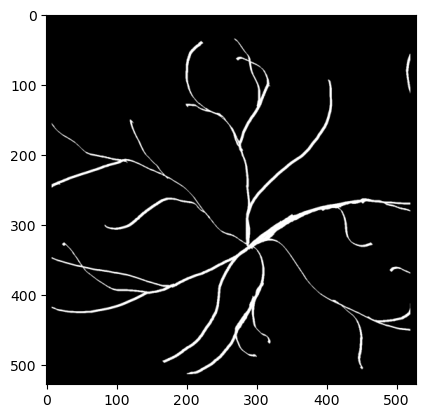

In [23]:
# validation_dataset = IOSTARDataset(root_dir =  './data_IOSTAR/test_images', transform=transforms.Compose([RandomCrop(128), GlobalContrastNormalization(), HeatMap(s=9, alpha=3, out_channels = 4), ToTensor(), Padding(0)])) 
validation_dataset = ULMDataset(root_dir =  './data_synthetic/test_images', transform=transforms.Compose([RandomCrop(1024),Rescale(512), HeatMap(s=9, alpha=3, out_channels = 4), ToTensor(), Padding(8)])) 
batch = validation_dataset[0]

data = 'synthetic'

im_tensor = batch['image'].unsqueeze(0)

# model = ULM_UNet(in_channels=3, init_features=64, threshold = 0.15, out_channels = 4)
# model.load_state_dict(torch.load('./weights/ulm_net_IOSTAR_epochs_1000_size_256_batch_4_out_channels_4_alpha_3.555774513043065_18_9_NoEndpoints_0.pt'))
Nt = 64

# output = model(im_tensor)

plt.figure(0)
plt.imshow(im_tensor[0,:,:].detach().numpy(), cmap = 'gray')
# plt.imshow((output[0,:-1,:,:].permute([1,2,0]).detach().numpy())*((output[0,:-1,:,:].permute([1,2,0]).detach().numpy()>0.15)+0.), cmap = 'jet', alpha = 0.5)

torch.Size([528, 528])
tensor(0)


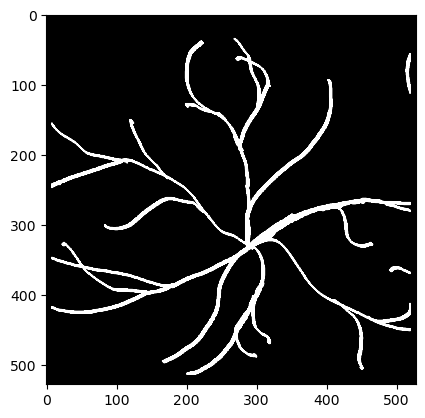

In [24]:
param_beta = .5
param_alpha = .5
im_tensor=im_tensor.squeeze()
scale = (.05,10)
step = 0.2

frangi_lambda = lambda x: frangi(x, beta=param_beta, scale_range=scale, scale_step=step, alpha=param_alpha)

# A = np.array([frangi_lambda(im_tensor[0].numpy()), frangi_lambda(im_tensor[1].numpy()), frangi_lambda(im_tensor[2].numpy())])*(im_tensor.mean(dim=0)>0.05).numpy()


# A = torch.tensor(A/A.max(axis=(1,2), keepdims=True)).mean(dim=0)**0.5
# A = torch.tensor(A).sum(dim=0)**.25

A = im_tensor

print(A.shape)

print(A.isnan().sum())

plt.imshow(A, cmap = 'gray',vmin=0.,vmax=1.)

0


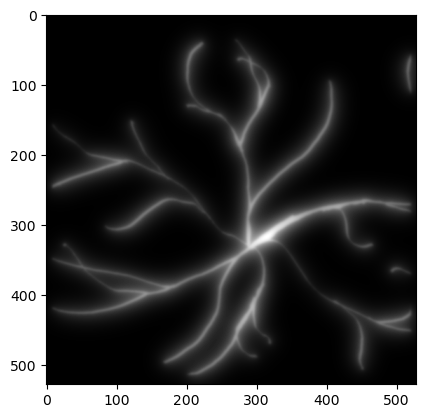

In [25]:
lifted_im_array = gaussian_OS(A, sigma = 0.005, eps = 0.1, N_o = Nt)
# lifted_im_array = Cake_OS(A, No = Nt, scale_min=1.5, scale_max=9.5).permute([1,2,0]).numpy()

print(np.isnan(lifted_im_array).sum())  

# print(lifted_im_array)

plt.imshow(lifted_im_array.sum(axis=2), cmap = 'gray')

In [26]:
from HFM_computations import Modify_Metric_and_Points

points_th = batch['landmarks']
points_th = points_th[points_th[:,0]>0]
print(points_th.shape)

# points = Detection_Model(model, batch, threshold=0.15)
points = points_th
# points=torch.tensor([[150,100,0],
#                      [200,140,0]])

points_tensor = torch.tensor(points).long()

lifted_im_array = lifted_im_array/lifted_im_array.max()

theta_indices = torch.tensor(lifted_im_array)[[points_tensor[:,1],points_tensor[:,0]]].argmax(dim=1)

th_bool = (points_th==points).all()

print(th_bool)
[Ad, points_tensor_mod, theta_indices_mod] = Modify_Metric_and_Points(torch.tensor(lifted_im_array).permute([1,0,2]), points_tensor, theta_indices, decalage = 5)

# W = Ad*(Ad*(Ad>0.5))+ 0. # for  ULM

W = (Ad.abs()/Ad.max())
W = (W*(W>0.0)) # for Synthetic

print(torch.isnan(torch.tensor(lifted_im_array)).sum())
    
points_array_3d = np.hstack([points_tensor_mod[:,:-1], theta_indices_mod.unsqueeze(1)])

torch.Size([34, 3])
tensor(True)
nombre de points : 36
tensor(0)


/tmp/ipykernel_3294520/462279412.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_tensor = torch.tensor(points).long()


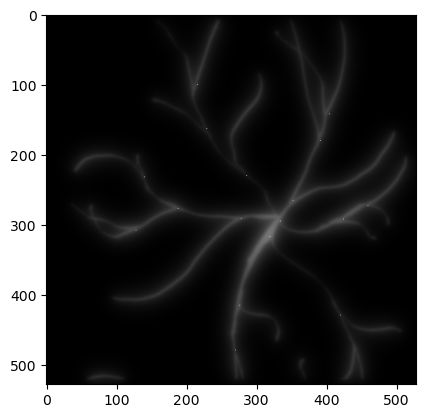

In [27]:
plt.imshow(Ad.sum(axis=2), cmap = 'gray')

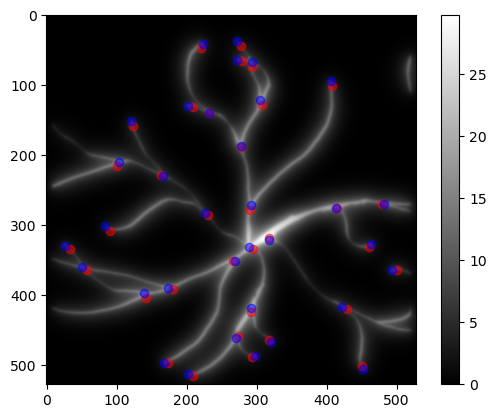

In [28]:
# plt.imshow((lifted_im_array/((lifted_im_array>0.1 + 0.)*lifted_im_array.max(axis=2, keepdims=True) + (1.-(lifted_im_array>0.2+0.)))).mean(axis=2), cmap='gray', vmin=0., vmax=1.)

plt.imshow(((lifted_im_array)).sum(axis=2), cmap='gray')
plt.colorbar()

# W = (lifted_im_array/((lifted_im_array>0.1 + 0.)*lifted_im_array.max(axis=2, keepdims=True) + (1.-(lifted_im_array>0.2+0.)))).mean(axis=2).T


# from HFM_computations import Modify_Metric_and_Points, Detection_Model, Show_Curves, Compute_Distance_Matrix



plt.scatter(points_tensor[:,1], points_tensor[:,0], c='r', alpha=0.5)
plt.scatter(points_th[:,1], points_th[:,0], c='b', alpha=0.5)  



In [29]:
# import napari
# # napari.view_image(W.numpy())
# viewer = napari.view_image(W.abs().sqrt().numpy())
# viewer.add_points(points_array_3d[:,[1,0,2]], face_color = 'r', size = 3)
# napari.run()

In [30]:
#%% Distance computation
from HFM_computations import Compute_Distance_Matrix
[D, L, hfmIn] = Compute_Distance_Matrix(1/(1+1000*W**4), points_tensor_mod, theta_indices_mod, alpha=0.5, xi=1/np.pi)  




528 528 64


100%|██████████| 35/35 [21:03<00:00, 36.11s/it]


Nombre de clusters etablis :1


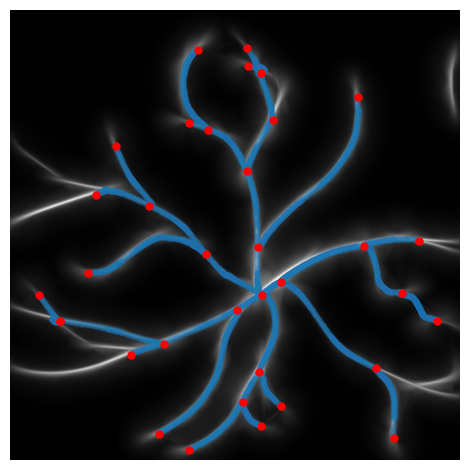

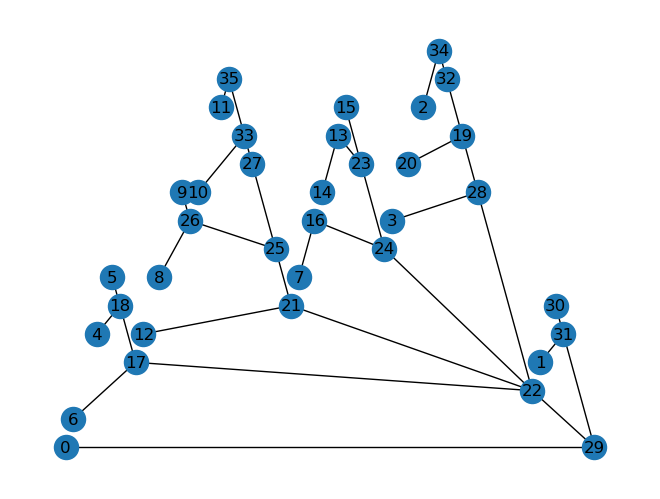

In [31]:
#%% Visualization
from HFM_computations import Cluster_from_Distance, Show_Tree, Show_Curves
# import napari

curves, list_of_stacks, Tcsr_list, prim_dict, labels = Cluster_from_Distance(D, L, distance_threshold=.2)
Show_Curves(W, im_tensor, points_tensor_mod, list_of_stacks, show_metric=True, th_output = th_bool, data=data)
Show_Tree(Tcsr_list[0], labels, prim_dict)

#%%
points_array_3d = np.hstack([points_tensor_mod[:,:-1], theta_indices_mod.unsqueeze(1)])

[Nx,Ny] = im_tensor.shape


In [32]:
import napari
viewer = napari.view_image((W).numpy()**.5)
viewer.add_points(points_array_3d[:,[1,0,2]], face_color = 'r', size = 3)
for i in range(len(list_of_stacks)):
    stacked_list = list_of_stacks[i]
    viewer.add_points(hfmIn.IndexFromPoint(stacked_list[:,::5].T)[0], face_color='b', size=1)